## Sample mock P1D (from model, not sim)

This notebook contains the basic syntax required to run a chain. We set up a mock data object from a given P1D model, construct an emulator and likelihood object, and pass these to a sampler to run for a small number of steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import emcee_sampler

In [2]:
# specify if you want to add high-resolution P1D (not working now)
add_hires=False
if add_hires:
    kmax_Mpc=8
else:
    kmax_Mpc=4

### Setup emulator

The emulator will be used both to make a mock, and in the likelihood 

In [3]:
# setup archive with P1D measurements from a simulation suite
test_nyx=True
if test_nyx:
    archive=nyx_archive.NyxArchive(zmax=4.5,verbose=False)
    emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'lambda_P']
    emulator=nn_emulator.NNEmulator(archive=archive,emu_params=emu_params,kmax_Mpc=kmax_Mpc)
else:
    archive=gadget_archive.GadgetArchive(postproc='Pedersen21')
    emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
    emulator=gp_emulator.GPEmulator(archive=archive,emu_params=emu_params,kmax_Mpc=kmax_Mpc)

Selected custom emulator
Use custom archive provided by the user
Training samples in archive : 3518


### Create mock P1D data

Use Lya theory to mimic mock data

In [4]:
data=mock_data.Mock_P1D(emulator=emulator,data_label="Chabanier2019")

In [5]:
# check if we also need mock extra_p1d
if True:
    extra_data=mock_data.Mock_P1D(emulator=emulator,data_label="Karacayli2022")
else:
    extra_data=None

Nz = 15 , Nk = 21


### Set free parameters and theory

In [6]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=0
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [7]:
theory=lya_theory.Theory(zs=data.z,emulator=emulator,free_param_names=free_param_names)

In [8]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 1e-09 , 3.2e-09
ns = 0.965 , 0.88 , 1.05
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [9]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [10]:
# Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,progress=True)

Created directory: /Users/font/Codes/igmhub/cup1d//chains//chain_5
setup with 8 walkers


In [11]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

As 2.1e-09 1e-09 3.2e-09
ns 0.965 0.88 1.05


In [12]:
n_burn_in=50
n_steps=500 
start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|█████████████████████████████████████████| 550/550 [07:22<00:00,  1.24it/s]

Sampling took 444.2 seconds


Mean values: [0.4996928224897807, 0.5006361503763858]


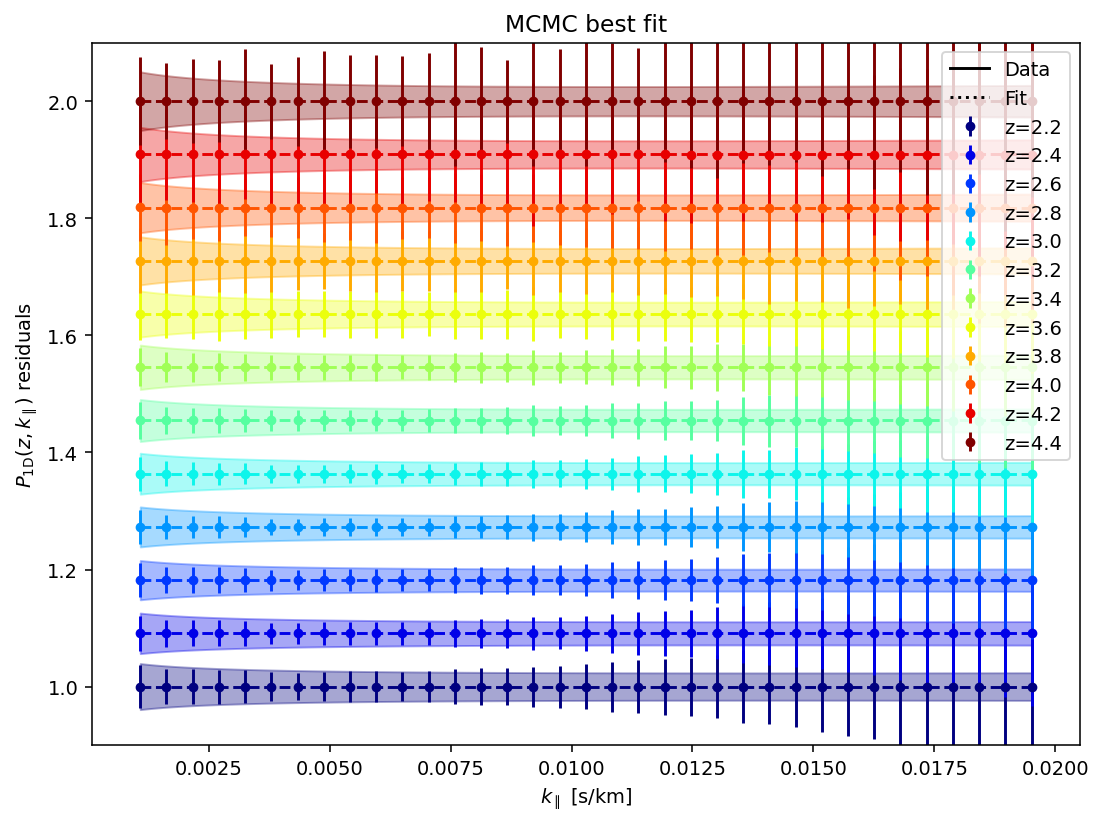

<Figure size 840x560 with 0 Axes>

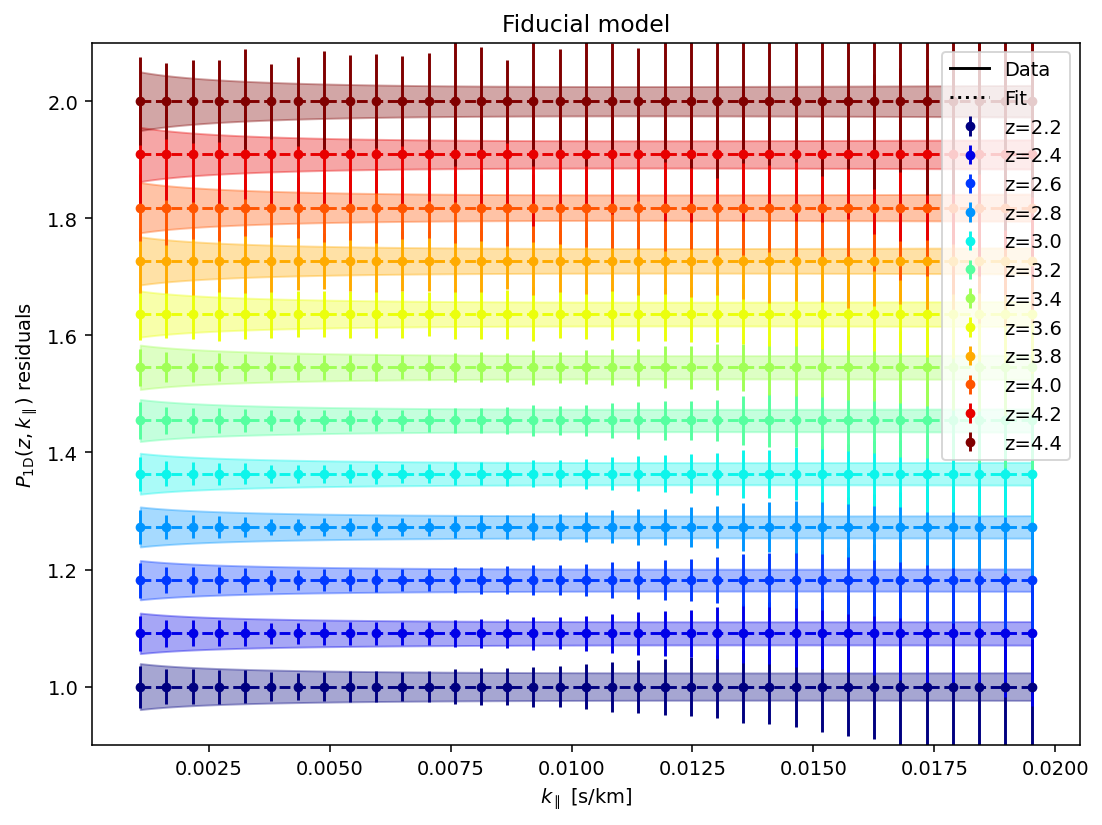

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1026: UserWarning:Attempting to set identical bottom == top == 0.9815916724832918 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1029: UserWarning:Attempting to set identical left == right == 0.9815916724832918 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1026: UserWarning:Attempting to set identical bottom == top == 0.9680008579459802 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/chainconsumer/plotter.py:1029: UserWarning:Attempting to set identical left == right == 0.9680008579459802 results in singular transformations; automatically expanding.
 /Users/font/opt/anaconda3/envs/lace_env/lib/pyt

Can't plot corner


<Figure size 840x560 with 0 Axes>

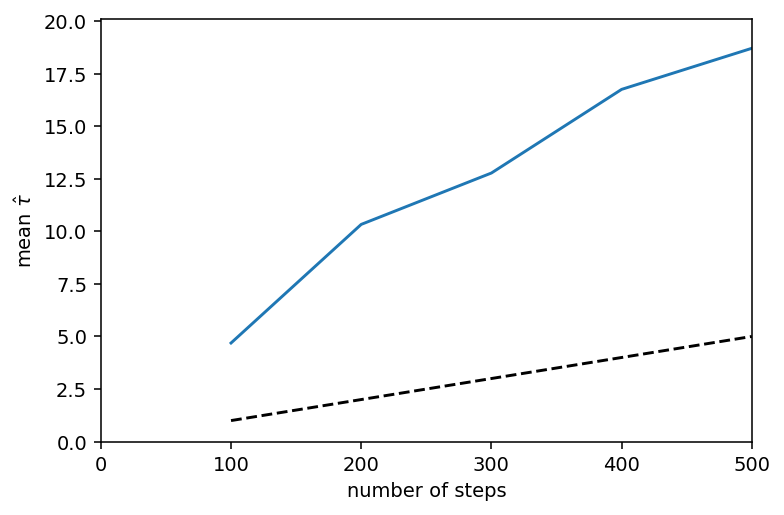

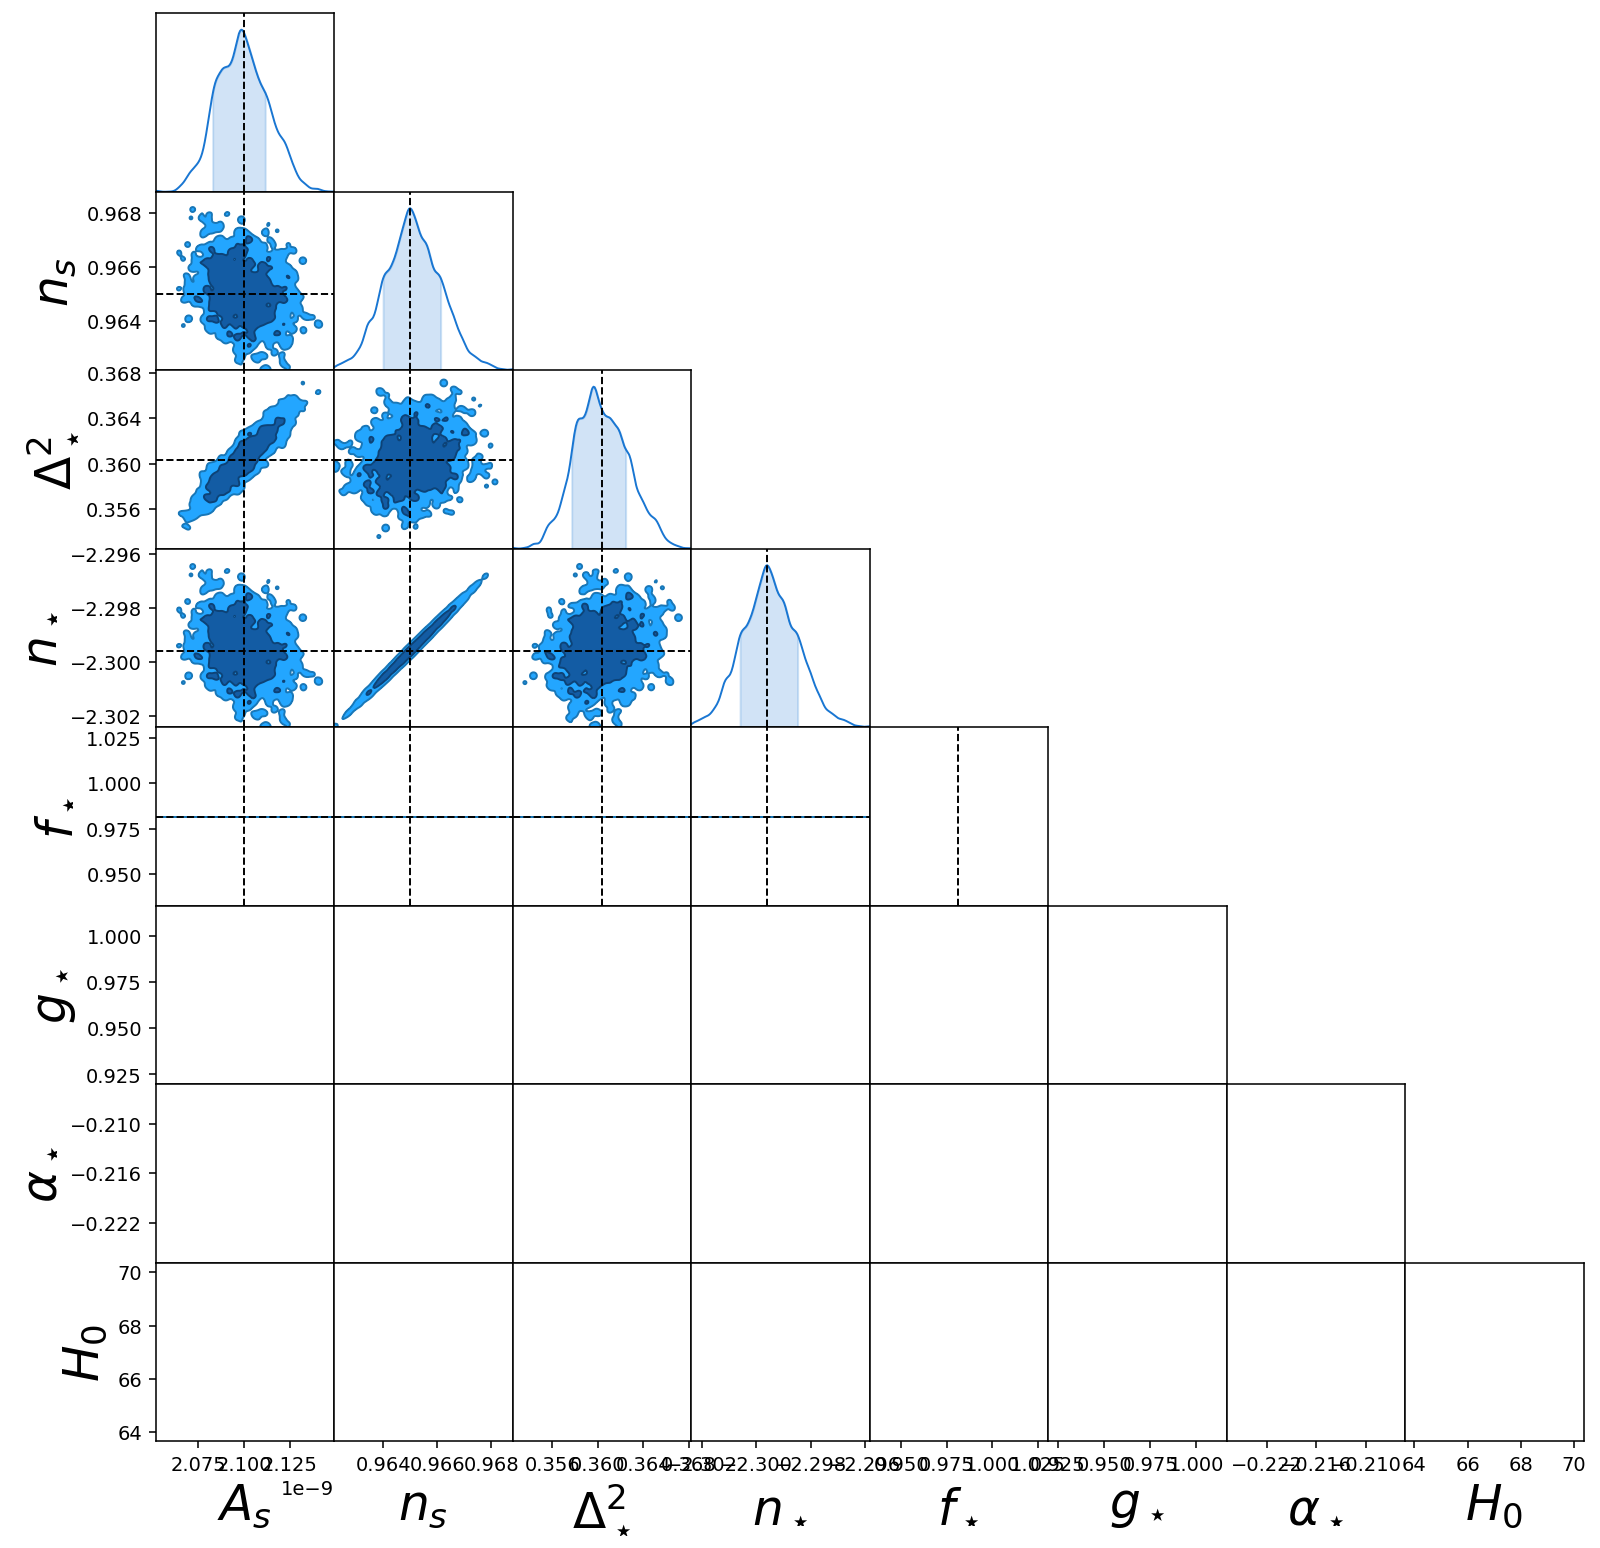

In [13]:
sampler.write_chain_to_file(residuals=True,plot_nersc=True,plot_delta_lnprob_cut=50)

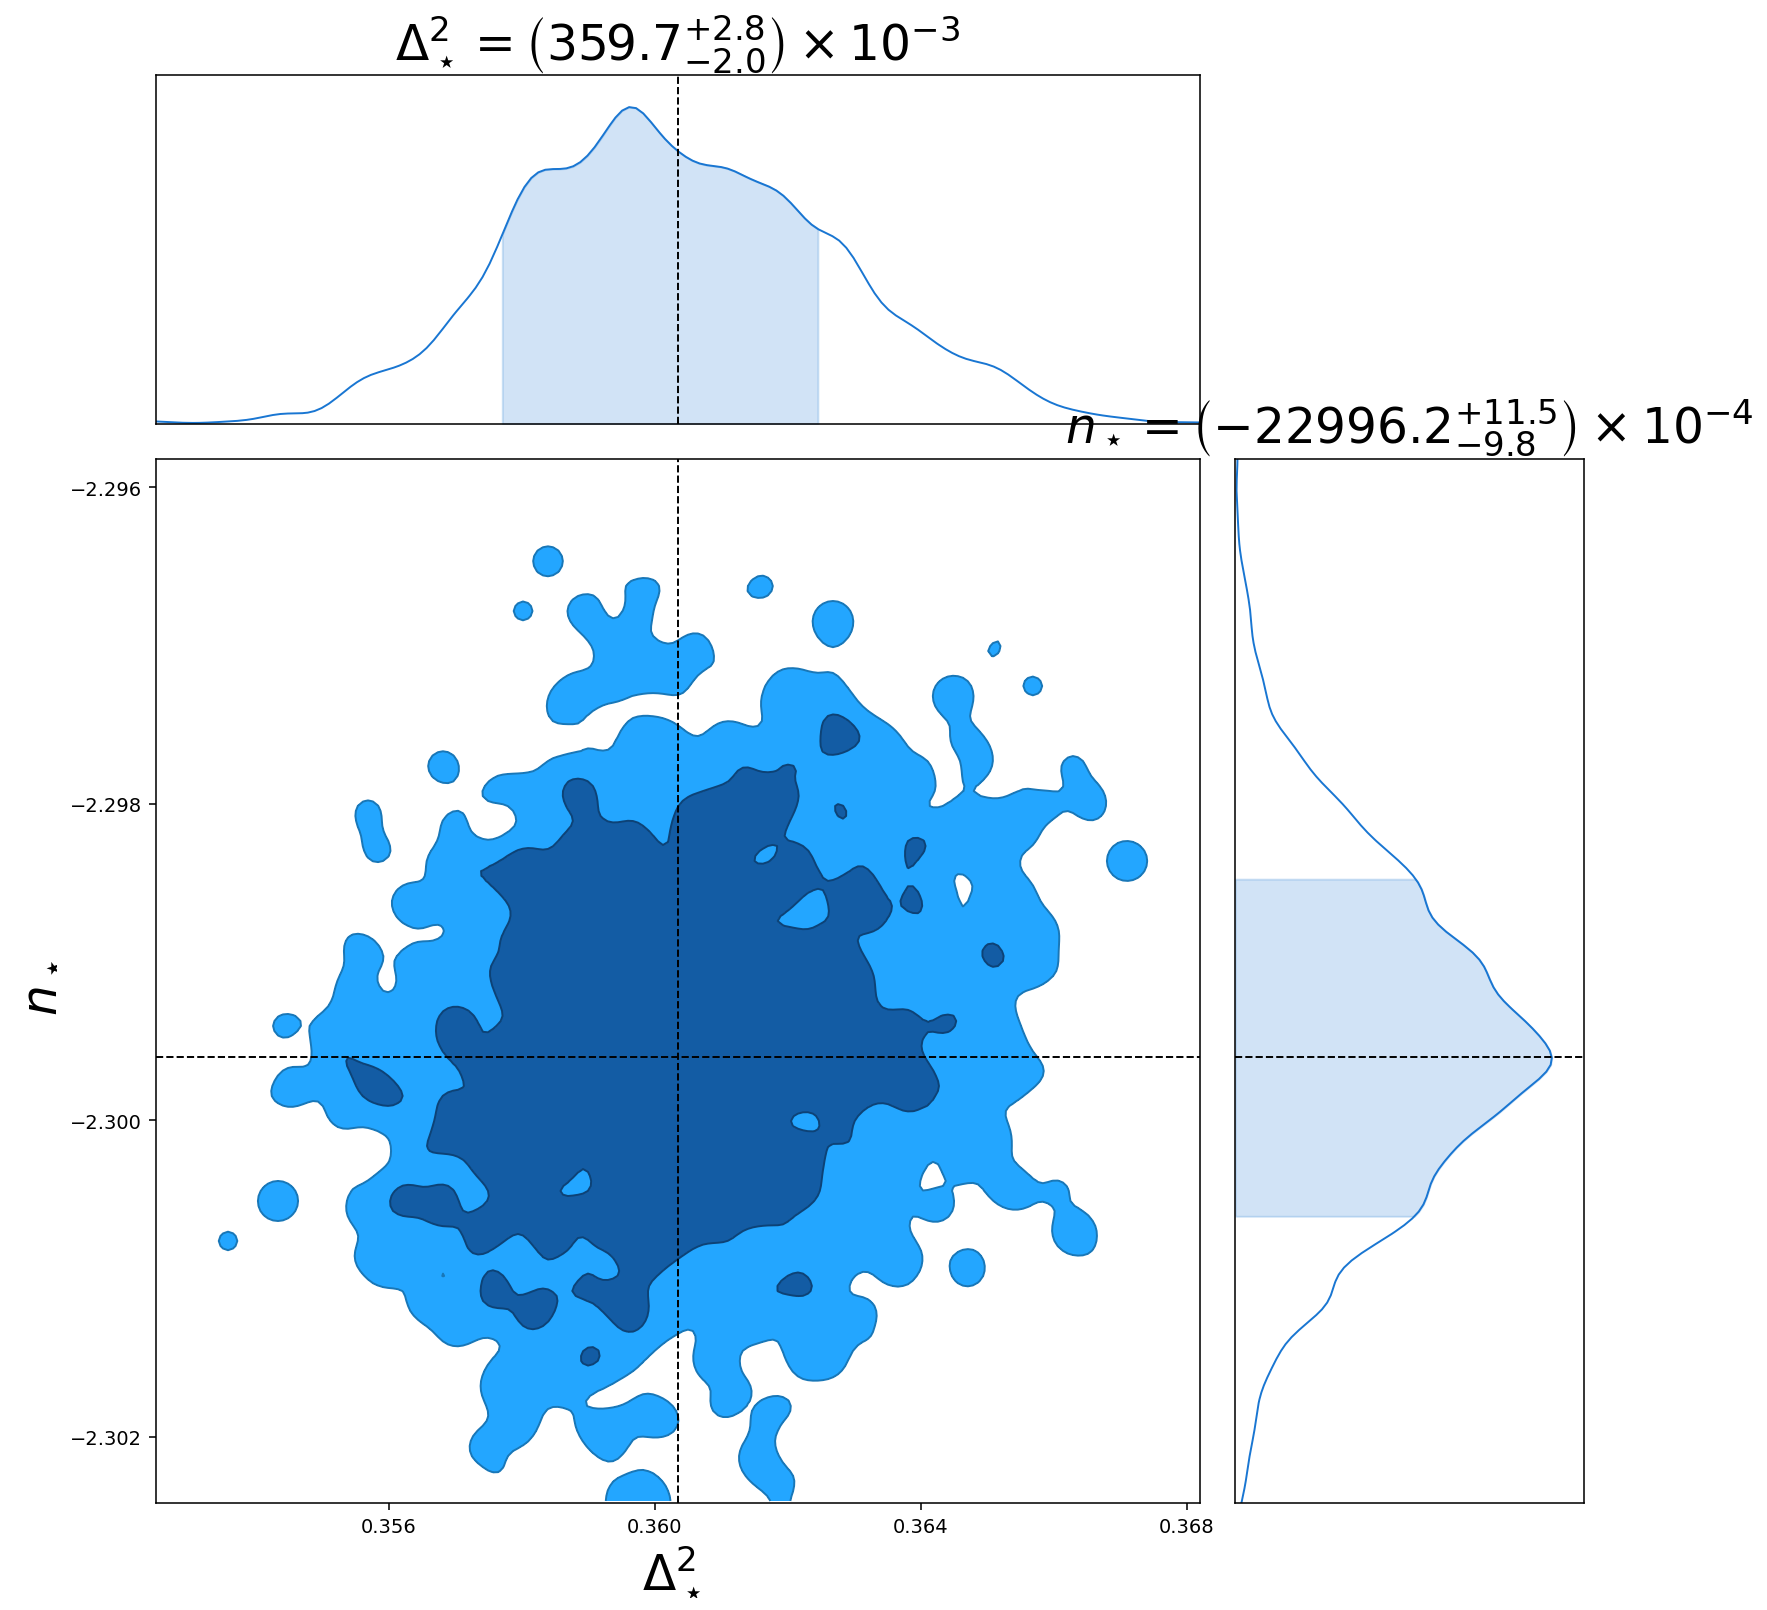

In [14]:
sampler.plot_corner(plot_params=['$\\Delta^2_\\star$','$n_\\star$'],
                    delta_lnprob_cut=50,usetex=False,serif=False)